# Determine P-value threshold at chosen a FDR threshold

In this notebook, we describe how to determine a P-value threshold for a given dataset so that the FDR is kept below a chosen threshold. We use an empirical method to estimate the FDR at given P-value thresholds. For a given P-value threshold ``p_thresh``, we proceed in four steps:

1. Determine the number of significant interactions ``sig_num_o`` at ``p_thresh``.
2. Randomize the simple and twisted read pair counts of all interactions. We randomize individual interactions with $n$ read pairs by randomly drawing a simple count from a binomial distribution with $p=0.5$ and then setting the twisted count to $t=n-s$.
3. Determine the number of randomized significant interactions ``sig_num_r`` at ``p_thresh``.
4. Use ``sig_num_r/sig_num_o`` to estimate the FDR at ``p_thresh``.

To find a P-value threshold for which the FDR is kept below a chosen threshold, we estimate the FDR for increasing P-value thresholds. Then we use the largest P-value threshold for which the FDR is still below the chosen threshold. Note that we randomize each interaction only once and then use the same list of P-values of randomized interactions for all P-value thresholds.

## Setting up the notebook

In [1]:
import sys
import os
import time
from numpy import arange
import pandas
sys.path.append("..")
from diachr import DiachromaticInteractionSet
from diachr import RandomizeInteractionSet

In this notebook, we use the following classes:
- ``DiachromaticInteractionSet``
- ``RandomizeInteractionSet``

We use the ``DiachromaticInteractionSet`` to read, evaluate, categorize and write interactions to a file. The randomization analyzes are carried out in class ``RandomizeInteractionSet``, which operates on an already existing ``DiachromaticInteractionSet`` object that has been passed to its constructor.

## Test files

### Test file 1

The purpose of the first test file is to check whether the P-value thresholds are used correctly during the FDR analysis. The function ``write_diachromatic_interaction_fdr_test_file`` of class ``DiachromaticInteractionSet`` can be used to generate a test file that contains the same number of interactions for consecutive P-value intervals of the same size. The following parameters must be specified:

- ``i_file``: Input interaction file
- ``p_value_max``: Maximum P-value
- ``p_value_step``: P-value step size
- ``i_per_interval_requested``: Requested number of interactions per interval
- ``target_file:``: Output interaction test file

Make sure that the interaction file has not previously been categorized with a P-value threshold that is smaller than the specified maximum P-value. Otherwise, interactions that do not have enough read pairs to be significant at the smaller threshold may have already been discarded.

The maximum P-value and the step size are used to create a list of P-values sorted in ascending order that define intervals of equal size. For example:

In [2]:
p_value_max = 0.05
p_value_step = 0.0025
p_threshs = arange(p_value_step, p_value_max + p_value_step, p_value_step)
print(p_threshs)

[0.0025 0.005  0.0075 0.01   0.0125 0.015  0.0175 0.02   0.0225 0.025
 0.0275 0.03   0.0325 0.035  0.0375 0.04   0.0425 0.045  0.0475 0.05  ]


For each of these intervals, the requested number of interactions is selected from the input file and written into a new interaction file that can be used for testing.

In order to create a test file for the FDR module, we first read an interactions file from real data into a ``DiachromaticInteractionSet``.

In [3]:
interaction_input_file = '../tests/data/test_03/MK_0.06_evaluated_and_categorized_interactions.tsv.gz'
interaction_set_test = DiachromaticInteractionSet()
interaction_set_test.parse_file(i_file = interaction_input_file, verbose=True)

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../tests/data/test_03/MK_0.06_evaluated_and_categorized_interactions.tsv.gz
	[INFO] Parsed 1,000,000 interaction lines ...
	[INFO] Parsed 2,000,000 interaction lines ...
	[INFO] Parsed 3,000,000 interaction lines ...
	[INFO] Parsed 4,000,000 interaction lines ...
	[INFO] Parsed 5,000,000 interaction lines ...
	[INFO] Parsed 6,000,000 interaction lines ...
	[INFO] Parsed 7,000,000 interaction lines ...
	[INFO] Parsed 8,000,000 interaction lines ...
	[INFO] Parsed 9,000,000 interaction lines ...
[INFO] ... done.


Then we create the test file with the function provided for this purpose. Note that we are using a smaller step size than in the example above.

In [4]:
write_test_file_info_dict = interaction_set_test.write_diachromatic_interaction_fdr_test_file(
    target_file='../tests/data/test_03/diachromatic_interaction_file_fdr_1.tsv',
    p_value_max = 0.05,
    p_value_step = 0.00025,
    i_per_interval_requested = 10,   
    verbose=True)

[INFO] Generating test file for FDR procedure ...
	[INFO] Iterating interaction set and writing interactions to test file ...
[INFO] ... done.


The function creates the new interaction file for testing and returns a table containing the number of selected interactions for each P-value interval. For the parameters given above, this table has rows for 200 intervals. For each interval, the current and cumulative number of selected interactions is reported.

In [5]:
pandas.set_option('display.max_rows', None)
pandas.DataFrame(write_test_file_info_dict['RESULTS_TABLE'])

,PVAL_INTERVAL,I_SELECTED,I_SELECTED_CUM
0,]0.00000;0.00025],10,10
1,]0.00025;0.00050],10,20
2,]0.00050;0.00075],10,30
3,]0.00075;0.00100],10,40
4,]0.00100;0.00125],10,50
5,]0.00125;0.00150],10,60
6,]0.00150;0.00175],10,70
7,]0.00175;0.00200],10,80
8,]0.00200;0.00225],10,90
9,]0.00225;0.00250],10,100


In this case, the requested number of 10 interactions could be selected for each of the 200 P-value intervals so that the output file contains 2000 interactions.

### Test files 2

To investigate the influence of the total number of input interactions on the estimation of the FDR, we created smaller files from a real interaction file by writing the top lines to new files. We have prepared test files with ``1,000``, ``2,000``, ``4,000``, ``8,000``, ``16,000``, ``32,000``, ``64,000`` and ``8,000,000`` interactions. We did not add the file with ``8,000,000`` to this repository because it's too large.

In [6]:
ls ../tests/data/test_03/*top*

../tests/data/test_03/diachromatic_interaction_file_fdr_top_1000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_16000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_2000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_32000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_4000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_8000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_8000000.tsv.gz


## Check that P-value thresholds are being used  correctly

During the FDR procedure, the number of sigificant interactions is determined at different P-value thresholds. In addition, P-values and logarithmized P-values are used. This can lead to errors when usinng ``<``, ``<=``, ``>`` or ``>=``. Furthermore, the transformations log(p) and exp(log(p)) can lead to inaccuracies. To check whether the thresholds are being used  correctly, we apply our FDR procedure to the test file, which contains the same number of interactions for different P-value intervals.

First, we read the test file into an ``DiachromaticInteractionSet``. When creating this file, we have defined 200 intervals and selected 10 interactions for each interval. Therefore, we expect a total of 2000 interactions.

In [2]:
interaction_set = DiachromaticInteractionSet()
interaction_set.parse_file('../tests/data/test_03/diachromatic_interaction_file_fdr_1.tsv', verbose=False)
read_file_info_report = interaction_set.get_read_file_info_report()
print(read_file_info_report)

[INFO] Report on reading files:
	[INFO] Read interaction data from 1 files:
		[INFO] 2,000 interactions from: 
			[INFO] ../tests/data/test_03/diachromatic_interaction_file_fdr_1.tsv
			[INFO] Minimum number of read pairs: 0
			[INFO] Skipped because less than 0 read pairs: 0
			[INFO] Added to set: 2,000
			[INFO] Set size: 2,000
	[INFO] The interaction set has 2,000 interactions.
[INFO] End of report.



Then we create an object of class ``RandomizeInteractionSet`` and, at the same time, pass the interaction set to this object. Finally, we call the function for the randomization procedure. This function expects a list of nominal alphas as input. We use the same values for the maximum P-value (``nominal_alpha_max``) and the step size (``nominal_alpha_step``) that we used when creating the test file.

In [3]:
# Create list of nominal alphas
nominal_alpha_max = 0.05
nominal_alpha_step = 0.00025
nominal_alphas = arange(nominal_alpha_step, nominal_alpha_max + nominal_alpha_step, nominal_alpha_step)

# Perform randomization procedure
randomize_fdr = RandomizeInteractionSet(random_seed = 0)
randomize_fdr_info_dict = randomize_fdr.perform_randomization_analysis(
    interaction_set = interaction_set,
    nominal_alphas = nominal_alphas,
    iter_num = 1,
    thread_num = 0,
    verbose = True)

[INFO] Performing randomization analysis with 1 iterations ...
	[INFO] Determining number of significant interactions at each nominal alpha ...
	[INFO] Randomizing interactions ...
		[INFO] Created RP_INTER_DICT for 2,000 interactions ...
		[INFO] Performing 1 iterations ...
			[INFO] First iteration indices: 0, ...
	[INFO] Combining results from all iterations for different nominal alphas ...
[INFO] ... done.


../diachr/randomize_interaction_set.py:453: UserWarning: Failed to calculate a Z-score for at least one nominal alpha!
  warnings.warn('Failed to calculate a Z-score for at least one nominal alpha!')


In this case, a warning is issued which is to be expected for this input and is explained later. The function returns a dictionary that is also stored in a class variable of the ``RandomizeInteractionSet`` object. This dictionary contains a table with the results.

In [4]:
pandas.set_option('display.max_rows', 10)
pandas.DataFrame(randomize_fdr_info_dict['RESULTS'])

,NOMINAL_ALPHA,SIG_NUM_R_GT_OBS,SIG_NUM_O,SIG_NUM_R_MEAN,SIG_NUM_R_SD,Z_SCORE,FDR
0,0.00025,0,10,1.0,0.0,NA,0.100000
1,0.00050,0,20,2.0,0.0,NA,0.100000
2,0.00075,0,30,2.0,0.0,NA,0.066667
3,0.00100,0,40,2.0,0.0,NA,0.050000
4,0.00125,0,50,3.0,0.0,NA,0.060000
...,...,...,...,...,...,...,...
195,0.04900,0,1960,78.0,0.0,NA,0.039796
196,0.04925,0,1970,80.0,0.0,NA,0.040609
197,0.04950,0,1980,80.0,0.0,NA,0.040404
198,0.04975,0,1990,81.0,0.0,NA,0.040704


Alternatively, the function ``get_randomization_info_table_row`` can be used to display the results for all nominal alphas in the passed list as a table.

In [7]:
print(randomize_fdr.get_randomization_info_table_row(description="<DESCRIPTION>"))

:TR_RANDOM:	DESCRIPTION	INPUT_I_NUM	ITER_NUM	RANDOM_SEED	NOMINAL_ALPHA	SIG_NUM_R_GT_OBS	SIG_NUM_O	SIG_NUM_R_MEAN	SIG_NUM_R_SD	Z_SCORE	FDR
:TR_RANDOM:	<DESCRIPTION>	2000	1	0	0.00025	0	10	1.00	0.00	NA	0.10000
:TR_RANDOM:	<DESCRIPTION>	2000	1	0	0.00050	0	20	2.00	0.00	NA	0.10000
:TR_RANDOM:	<DESCRIPTION>	2000	1	0	0.00075	0	30	2.00	0.00	NA	0.06667
:TR_RANDOM:	<DESCRIPTION>	2000	1	0	0.00100	0	40	2.00	0.00	NA	0.05000
:TR_RANDOM:	<DESCRIPTION>	2000	1	0	0.00125	0	50	3.00	0.00	NA	0.06000
:TR_RANDOM:	<DESCRIPTION>	2000	1	0	0.00150	0	60	3.00	0.00	NA	0.05000
:TR_RANDOM:	<DESCRIPTION>	2000	1	0	0.00175	0	70	3.00	0.00	NA	0.04286
:TR_RANDOM:	<DESCRIPTION>	2000	1	0	0.00200	0	80	3.00	0.00	NA	0.03750
:TR_RANDOM:	<DESCRIPTION>	2000	1	0	0.00225	0	90	4.00	0.00	NA	0.04444
:TR_RANDOM:	<DESCRIPTION>	2000	1	0	0.00250	0	100	4.00	0.00	NA	0.04000
:TR_RANDOM:	<DESCRIPTION>	2000	1	0	0.00275	0	110	5.00	0.00	NA	0.04545
:TR_RANDOM:	<DESCRIPTION>	2000	1	0	0.00300	0	120	6.00	0.00	NA	0.05000
:TR_RANDOM:	<DESCRIPTION>	2000	

This table consists of the following columns:

- ``:TR_RANDOM:``: Tag that can be used to extract the table from text files
- ``OUT_PREFIX``: Field for a short description (can be passed as an argument to ``get_randomization_info_table_row``)
- ``INPUT_I_NUM``: Number of interaction that were passed to the randomization procedure
- ``ITER_NUM``: Number of performed iterations
- ``RANDOM_SEED``: Random seed used
- ``NOMINAL_ALPHA``: Each row contains the results for one nominal alpha of the list that was passed to the randomization procedure
- ``SIG_NUM_R_GT_OBS``: Number of iterations in which there were more significant interactions after randomization than before
- ``SIG_NUM_O``: Number of significant interactions before randomization
- ``SIG_NUM_R_MEAN``: Mean number of significant randomized interactions
- ``SIG_NUM_R_SD``: Standard deviation of significant randomized interactions
- ``Z_SCORE``: Z-score calculated from ``SIG_NUM_O``, ``SIG_NUM_R_MEAN`` and ``SIG_NUM_R_SD``
- ``FDR``: Estimated FDR calculated from ``SIG_NUM_O`` and ``SIG_NUM_R_MEAN``

The number of significant interactions in column ``SIG_NUM_O`` increases by 10 for each nominal alpha. This is what we expect for this test dataset.

A list of nominal alphas can also be passed to the function ``get_randomization_info_table_row``, so that only the corresponding lines are output.

In [13]:
print(randomize_fdr.get_randomization_info_table_row(nominal_alphas_selected=[0.02500, 0.05000], description="<DESCRIPTION>"))

:TR_RANDOM:	DESCRIPTION	INPUT_I_NUM	ITER_NUM	RANDOM_SEED	NOMINAL_ALPHA	SIG_NUM_R_GT_OBS	SIG_NUM_O	SIG_NUM_R_MEAN	SIG_NUM_R_SD	Z_SCORE	FDR
:TR_RANDOM:	<DESCRIPTION>	2000	1	0	0.02500	0	1000	42.00	0.00	NA	0.04200
:TR_RANDOM:	<DESCRIPTION>	2000	1	0	0.05000	0	2000	81.00	0.00	NA	0.04050



## Influence of the total number of interactions on the estimation of the FDR

We investigated the influence of the total number of input interactions on the estimation of the FDR by downsampling. From an interaction file with approximately ``9,000,000`` interactions, we created eight smaller interaction files by writing the first ``1,000``, ``2,000``, ``4,000``, ``8,000``, ``16,000``, ``32,000``, ``64,000`` and ``8,000,000`` lines each to a new file. Then we applied our FDR procedure with the same parameters to all files.

In [7]:
chosen_fdr_thresh = 0.05
p_value_max = 0.025
p_value_step = 0.00025

### ``1,000`` interactions

In [2]:
# Create list of nominal alphas
nominal_alpha_max = 0.05
nominal_alpha_step = 0.00025
nominal_alphas = arange(nominal_alpha_step, nominal_alpha_max + nominal_alpha_step, nominal_alpha_step)

# Prepare interaction set
interaction_file_top_1000 = '../tests/data/test_03/diachromatic_interaction_file_fdr_top_1000.tsv.gz'
interaction_set_top_1000 = DiachromaticInteractionSet()
interaction_set_top_1000.parse_file(interaction_file_top_1000, verbose=False)

# Perform randomization procedure
randomize_fdr = RandomizeInteractionSet(random_seed = 0)
randomize_fdr_info_dict = randomize_fdr.perform_randomization_analysis(
    interaction_set = interaction_set_top_1000,
    nominal_alphas = nominal_alphas,
    iter_num = 1,
    thread_num = 0,
    verbose = True)

[INFO] Performing randomization analysis with 1 iterations ...
	[INFO] Determining number of significant interactions at each nominal alpha ...
	[INFO] Randomizing interactions ...
		[INFO] Created RP_INTER_DICT for 1,000 interactions ...
		[INFO] Performing 1 iterations ...
			[INFO] First iteration indices: 0, ...
	[INFO] Combining results from all iterations for different nominal alphas ...
[INFO] ... done.


../diachr/randomize_interaction_set.py:453: UserWarning: Failed to calculate a Z-score for at least one nominal alpha!
  warnings.warn('Failed to calculate a Z-score for at least one nominal alpha!')


In this case, a warning is reported because no Z-score could be calculated for at least one nominal alpha. This is because we performed only one iteration, which is why the standard deviation is zero for all nominal alphas.

The function ``get_randomization_info_report_at_chosen_fdr_threshold`` can be used to query the results of the randomization for the largest nominal alpha for which the FDR is still below a chosen theshold.

In [3]:
print(randomize_fdr.get_randomization_info_report_at_chosen_fdr_threshold(
    chosen_fdr_threshold = 0.05))

[INFO] Report on randomization:
	[INFO] Input parameters:
		[INFO] Number of input interactions: 1,000
		[INFO] Number of iterations: 1
		[INFO] Random seed: 0
		[INFO] Available nominal alphas: 
			0.00025, 0.00050, 0.00075, ..., 0.05000
	[INFO] Results for a nominal alpha of 0.00400:
		[INFO] Number of randomized interactions: 1,000
		[INFO] Significant randomized interaction numbers: 
			1
		[INFO] Iterations with more significant interactions than observed: 0
		[INFO] Original number of significant interactions: 23
		[INFO] Mean number of significant randomized interactions: 1.00
		[INFO] Standard deviation of significant randomized interactions: 0.00
		[INFO] Z-score: NA (Increase number of iterations!)
		[INFO] Estimated FDR: 0.04348
[INFO] End of report.



In this case, with only ``1,000`` interactions, a P-value threshold of ``0.00400`` is determined. This is the largest P-value threshold for which an FDR was estimated that was still below ``0.05``.  We use this threshold to categorize interactions as either directed or undirected. ``23`` significant interactions were observed for the original data. After the simple and twisted read pair counts of all interactions were randomized, the number of significant interactions was ``1``. This gives an estimated FDR of ``1/23 = 0.04348``.

The function ``get_randomization_info_plot_at_chosen_fdr_threshold`` can be used to get a detailed representation of all results. A text field in the header contains all informations that is also contained in the formatted string described above. Below that follows the first plot, which only contains the P-value thresholds that were passed through. The red dashed lines are drawn at the determined P-value threshold. This is followed by two plots that refer to the minimum number of read pairs that are necessary for significance at the various P-value thresholds. These upper three plots do not contain results related to the data. They result soley from the binomial model and the chosen step size for the P-value thresholds and serve as a reference for the interpretation for the lower three plots. The one plot shows the number of significant interactions for the original (orange) and randomized (blue) data. Below that is a plot for the Z-scores and another one for the FDR.

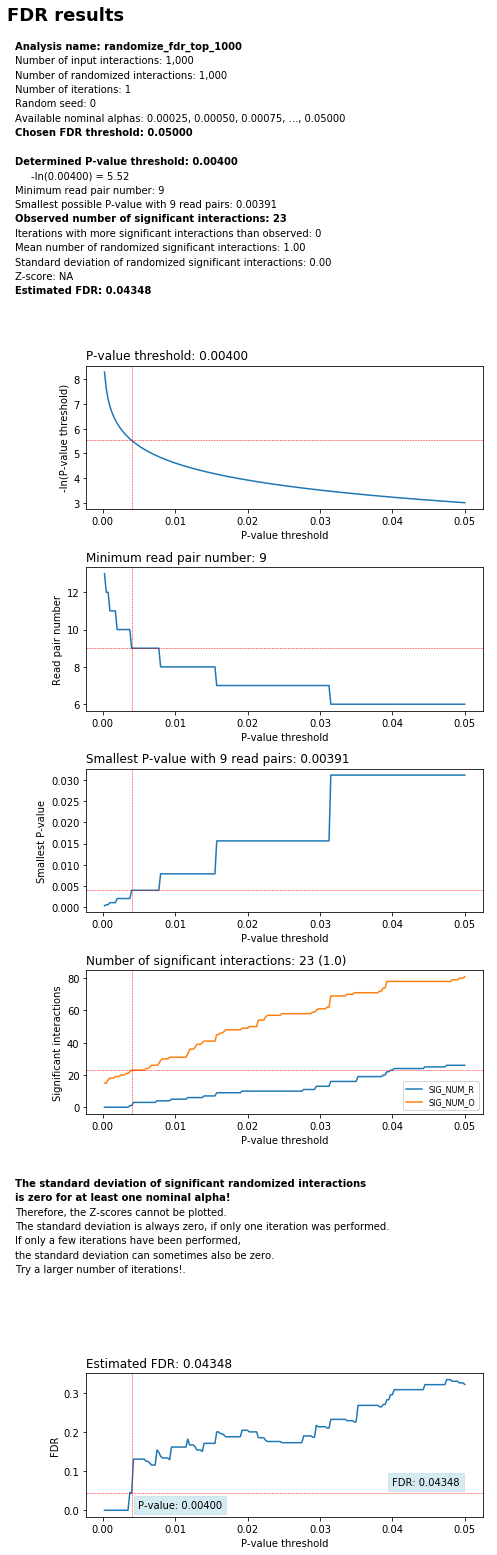

In [6]:
# Create FDR plot
fig = randomize_fdr.get_randomization_info_plot_at_chosen_fdr_threshold(
    chosen_fdr_threshold = 0.05,
    pdf_file_name = 'randomize_fdr_top_1000_iter_num_1.pdf',
    description = 'Randomize_fdr_top_1000_iter_1')

In this example, with a small number of input interactions and only a single iteration, the FDR estimated for different nominal alphas shows an unsual trend. First of all, it is nocticable that the FDR increases sharply at some P-value thresholds especially the one that was determined as the largest threshold that yields an FDR which is still below the chosen FDR threshold of ``0.05``. In addition, it happens that the FDR decreases with increasing P-value thresholds. Typically, one would expect the FDR to grow monotonically with the P-value threshold. In thus case the FDR could not be reliably estimated and the P-value threshold should not be used.

In a next step, we repeat the analysis with a larger number of iterations.

In [23]:
# Perform randomization procedure
randomize_fdr = RandomizeInteractionSet(random_seed = 0)
randomize_fdr_info_dict = randomize_fdr.perform_randomization_analysis(
    interaction_set = interaction_set_top_1000,
    nominal_alphas = nominal_alphas,
    iter_num = 50,
    thread_num = 2,
    verbose = True)

[INFO] Performing randomization analysis with 50 iterations ...
	[INFO] Determining number of significant interactions at each nominal alpha ...
	[INFO] Randomizing interactions ...
		[INFO] Created RP_INTER_DICT for 1,000 interactions ...
		[INFO] Performing 25 iterations ...
			[INFO] First iteration indices: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...
		[INFO] Performing 25 iterations ...
			[INFO] First iteration indices: 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, ...
	[INFO] Combining results from all iterations for different nominal alphas ...
[INFO] ... done.


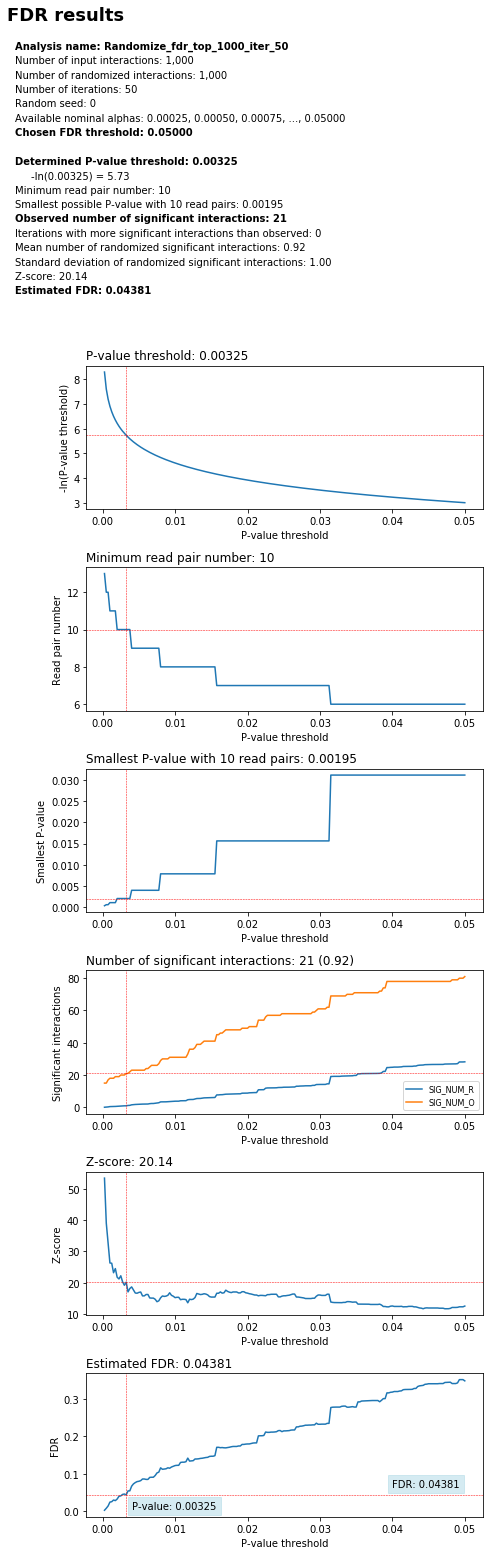

In [24]:
fig = randomize_fdr.get_randomization_info_plot_at_chosen_fdr_threshold(
    chosen_fdr_threshold = 0.05,
    pdf_file_name = 'randomize_fdr_top_1000_iter_num_50.pdf',
    description = 'Randomize_fdr_top_1000_iter_50')

In this case, the FDR increases with nominal alpha and we determine a P-value threshold of ``0.00325`` for which the FDR is still below ``0.05``. Increases in the FDR can still be observed at the transitions to fewer read pairs, which are required for significance at the corresponding nominal alpha.

### ``64,000`` interactions

Next, we apply our FDR procedure to the file with ``64,000`` interactions.

In [29]:
# Prepare interaction set
interaction_file_top_64000 = '../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz'
interaction_set_top_64000 = DiachromaticInteractionSet()
interaction_set_top_64000.parse_file(interaction_file_top_64000, verbose=False)

# Perform randomization procedure
randomize_fdr = RandomizeInteractionSet(random_seed = 0)
randomize_fdr_info_dict = randomize_fdr.perform_randomization_analysis(
    interaction_set = interaction_set_top_64000,
    nominal_alphas = nominal_alphas,
    iter_num = 1,
    thread_num = 0,
    verbose = True)

[INFO] Performing randomization analysis with 1 iterations ...
	[INFO] Determining number of significant interactions at each nominal alpha ...
	[INFO] Randomizing interactions ...
		[INFO] Created RP_INTER_DICT for 64,000 interactions ...
		[INFO] Performing 1 iterations ...
			[INFO] First iteration indices: 0, ...
	[INFO] Combining results from all iterations for different nominal alphas ...
[INFO] ... done.


../diachr/randomize_interaction_set.py:453: UserWarning: Failed to calculate a Z-score for at least one nominal alpha!
  warnings.warn('Failed to calculate a Z-score for at least one nominal alpha!')


Again a warning is reported because we performed only one iteration.

We again use the function ``get_randomization_info_plot_at_chosen_fdr_threshold`` to display the results.

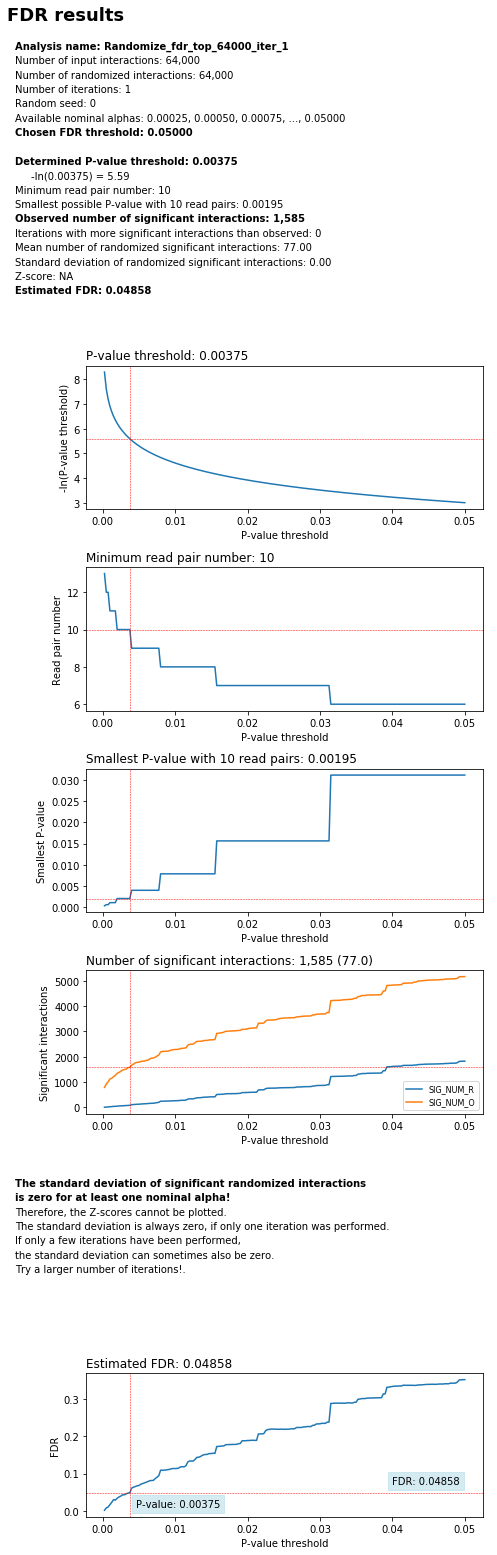

In [30]:
fig = randomize_fdr.get_randomization_info_plot_at_chosen_fdr_threshold(
    chosen_fdr_threshold = 0.05,
    pdf_file_name = 'randomize_fdr_top_64000_iter_num_1.pdf',
    description = 'Randomize_fdr_top_64000_iter_1')

For this example, the FDR increases monotonically as expected, even though we performed only one iteration. An abrupt increase in the FDR can be seen at the transition from ``7`` to ``6`` read pairs required for significance. The largest nominal alpha for which the FDR is still below ``0.05`` is ``0.00375``.

We increase the number of iterations to ``50``.

In [31]:
# Perform randomization procedure
randomize_fdr = RandomizeInteractionSet(random_seed = 0)
randomize_fdr_info_dict = randomize_fdr.perform_randomization_analysis(
    interaction_set = interaction_set_top_64000,
    nominal_alphas = nominal_alphas,
    iter_num = 50,
    thread_num = 0,
    verbose = True)

[INFO] Performing randomization analysis with 50 iterations ...
	[INFO] Determining number of significant interactions at each nominal alpha ...
	[INFO] Randomizing interactions ...
		[INFO] Created RP_INTER_DICT for 64,000 interactions ...
		[INFO] Performing 50 iterations ...
			[INFO] First iteration indices: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...
	[INFO] Combining results from all iterations for different nominal alphas ...
[INFO] ... done.


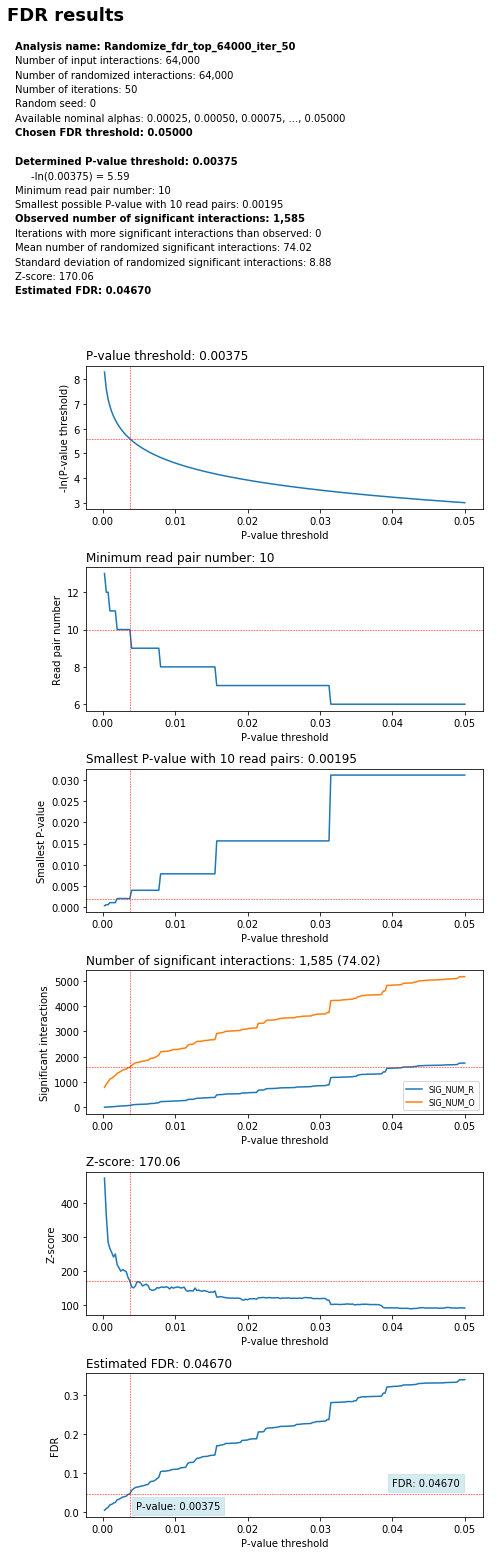

In [32]:
fig = randomize_fdr.get_randomization_info_plot_at_chosen_fdr_threshold(
    chosen_fdr_threshold = 0.05,
    pdf_file_name = 'randomize_fdr_top_64000_iter_num_50.pdf',
    description = 'Randomize_fdr_top_64000_iter_50')

The shape of the curve for the FDR looks very similar and we determine the same P-value threshold (``0.00375``) as before with only one iteration.

In this case, no warning is issued. The determined P-value threshold is ``0.00375``. At this P-value threshold is with ``0.04858`` below the specified ``0.05``.

### ``1,000``, ``2,000``, ``4,000``, ``8,000``, ``16,000``, ``32,000``, ``64,000`` interactions

In order to get an impression of how many input interactions are needed for a reliable estimate of the FDR, we apply the procedure to all prepared files.

In [89]:
fdr_results = {}
for i_num in [1000, 2000, 4000, 8000, 16000, 32000, 64000]:
    
    # Prepare interaction set
    i_file = '../tests/data/test_03/diachromatic_interaction_file_fdr_top_' + str(i_num) +'.tsv.gz'
    print(i_file)
    i_set = DiachromaticInteractionSet()
    i_set.parse_file(i_file, verbose=False)

    # Perform randomization procedure
    randomize_fdr = RandomizeInteractionSet(random_seed=0)
    fdr_results[i_num] = randomize_fdr.perform_randomization_analysis(
        interaction_set = i_set,
        nominal_alphas = nominal_alphas,
        iter_num = 1,
        thread_num = 2,
        verbose = False)
    
    time.sleep(1)
print("... done.")

../tests/data/test_03/diachromatic_interaction_file_fdr_top_1000.tsv.gz


../diachr/randomize_interaction_set.py:453: UserWarning: Failed to calculate a Z-score for at least one nominal alpha!
  warnings.warn('Failed to calculate a Z-score for at least one nominal alpha!')


../tests/data/test_03/diachromatic_interaction_file_fdr_top_2000.tsv.gz


../diachr/randomize_interaction_set.py:453: UserWarning: Failed to calculate a Z-score for at least one nominal alpha!
  warnings.warn('Failed to calculate a Z-score for at least one nominal alpha!')


../tests/data/test_03/diachromatic_interaction_file_fdr_top_4000.tsv.gz


../diachr/randomize_interaction_set.py:453: UserWarning: Failed to calculate a Z-score for at least one nominal alpha!
  warnings.warn('Failed to calculate a Z-score for at least one nominal alpha!')


../tests/data/test_03/diachromatic_interaction_file_fdr_top_8000.tsv.gz


../diachr/randomize_interaction_set.py:453: UserWarning: Failed to calculate a Z-score for at least one nominal alpha!
  warnings.warn('Failed to calculate a Z-score for at least one nominal alpha!')


../tests/data/test_03/diachromatic_interaction_file_fdr_top_16000.tsv.gz


../diachr/randomize_interaction_set.py:453: UserWarning: Failed to calculate a Z-score for at least one nominal alpha!
  warnings.warn('Failed to calculate a Z-score for at least one nominal alpha!')


../tests/data/test_03/diachromatic_interaction_file_fdr_top_32000.tsv.gz


../diachr/randomize_interaction_set.py:453: UserWarning: Failed to calculate a Z-score for at least one nominal alpha!
  warnings.warn('Failed to calculate a Z-score for at least one nominal alpha!')


../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz


../diachr/randomize_interaction_set.py:453: UserWarning: Failed to calculate a Z-score for at least one nominal alpha!
  warnings.warn('Failed to calculate a Z-score for at least one nominal alpha!')


... done.


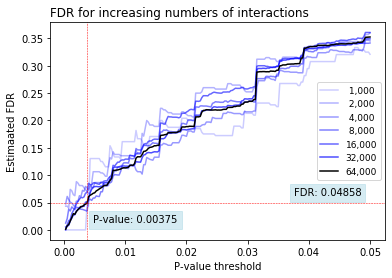

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline

pval_threshs = fdr_results[1000]['RESULTS']['NOMINAL_ALPHA']

plt.plot(pval_threshs, fdr_results[1000]['RESULTS']['FDR'], color=(0,0,1,0.2), label=' ' + "{:,}".format(1000))
plt.plot(pval_threshs, fdr_results[2000]['RESULTS']['FDR'], color=(0,0,1,0.3), label=' ' + "{:,}".format(2000))
plt.plot(pval_threshs, fdr_results[4000]['RESULTS']['FDR'], color=(0,0,1,0.4), label=' ' + "{:,}".format(4000))
plt.plot(pval_threshs, fdr_results[8000]['RESULTS']['FDR'], color=(0,0,1,0.5), label=' ' + "{:,}".format(8000))
plt.plot(pval_threshs, fdr_results[16000]['RESULTS']['FDR'], color=(0,0,1,0.6), label="{:,}".format(16000))
plt.plot(pval_threshs, fdr_results[32000]['RESULTS']['FDR'], color=(0,0,1,0.7), label="{:,}".format(32000))
plt.plot(pval_threshs, fdr_results[64000]['RESULTS']['FDR'], color=(0,0,0,1), label="{:,}".format(64000))

result_index = randomize_fdr.get_largest_nominal_alpha_index_at_chosen_fdr_thresh(0.05)

fdr_result = fdr_results[64000]['RESULTS']['FDR'][result_index]
pval_thresh_result = fdr_results[64000]['RESULTS']['NOMINAL_ALPHA'][result_index]
plt.axhline(fdr_result, linestyle='--', color='red', linewidth=0.5)
plt.axvline(pval_thresh_result, linestyle='--', color='red', linewidth=0.5)

fdr_max = max(fdr_results[64000]['RESULTS']['FDR'])
pval_max = max(fdr_results[64000]['RESULTS']['NOMINAL_ALPHA'])
fdr_x = pval_max - pval_max/4
fdr_y = fdr_result + fdr_max/25
pval_x = pval_thresh_result + pval_max/50
pval_y = fdr_result - fdr_max/10
plt.text(fdr_x, fdr_y,'FDR: ' + "{:.5f}".format(fdr_result), bbox={'color': 'lightblue', 'alpha': 0.5, 'pad': 4})
plt.text(pval_x, pval_y,'P-value: ' + "{:.5f}".format(pval_thresh_result), bbox={'color': 'lightblue', 'alpha': 0.5, 'pad': 4})
plt.xlabel('P-value threshold')
plt.ylabel('Estimaated FDR')

plt.title('FDR for increasing numbers of interactions', loc='left')
plt.legend(fontsize=9)

plt.savefig('fdr_for_increasing_numbers_of_interactions.pdf')
plt.show()

The black line shows the FDR estimates for ``64,000`` input interactions. For the other interaction numbers, the FDR estimates are shown in blue, with the lines becoming darker with increasing interaction numbers. Up to ``16,000`` input interactions the FDR estimates show unusual trends. From ``32,000`` onwards, the estimates stabilize.

### ``8,000,000`` interactions

Finally, we wanted to find out how the estimates change beyond ``64,000`` input interactions. We applied the procedure to the file with ``8,000,000`` interactions.

In [86]:
# Prepare interaction set
interaction_file_top_8000000 = '../tests/data/test_03/diachromatic_interaction_file_fdr_top_8000000.tsv.gz'
interaction_set_top_8000000 = DiachromaticInteractionSet()
interaction_set_top_8000000.parse_file(interaction_file_top_8000000, verbose=False)

# Perform randomization
randomize_fdr_top_8000000 = RandomizeInteractionSet(random_seed=0)
fdr_info_dict_top_8000000 = randomize_fdr_top_8000000.perform_randomization_analysis(
    interaction_set = interaction_set_top_8000000,
    nominal_alphas = nominal_alphas,
    iter_num = 1,
    thread_num = 0,
    verbose = True)

[INFO] Performing randomization analysis with 1 iterations ...
	[INFO] Determining number of significant interactions at each nominal alpha ...
	[INFO] Randomizing interactions ...
		[INFO] Created RP_INTER_DICT for 8,000,000 interactions ...
		[INFO] Performing 1 iterations ...
			[INFO] First iteration indices: 0, ...
	[INFO] Combining results from all iterations for different nominal alphas ...
[INFO] ... done.


../diachr/randomize_interaction_set.py:453: UserWarning: Failed to calculate a Z-score for at least one nominal alpha!
  warnings.warn('Failed to calculate a Z-score for at least one nominal alpha!')


Because the file with ``8,000,000`` is too large to add to the repository, the results can also be read into variables by running the cell below.

In [55]:
#str(fdr_info_dict_top_8000000['RESULTS']['FDR'])
#randomize_fdr_top_8000000.get_largest_nominal_alpha_index_at_chosen_fdr_thresh(0.05)

In [87]:
randomize_fdr_top_8000000_fdr_list = [0.005196442038492928, 0.009357641487011101, 0.012801690758905524, 0.018780636366273168, 0.02004606509688462, 0.023559894755118667, 0.02576442659111344, 0.033003459166791996, 0.03458045554739162, 0.03753835663143539, 0.040477368971016885, 0.04146960558857986, 0.04254578558423477, 0.04708356426207261, 0.04837631693069054, 0.05682361867572649, 0.06035963537622416, 0.06379918464568733, 0.06511014330375697, 0.0654448259259426, 0.06690383240287974, 0.06789198621625671, 0.06840115476779793, 0.07019568186139778, 0.07068605281033163, 0.07688625047874377, 0.07916091478476014, 0.0793495642358484, 0.08210267652798188, 0.08602057475560101, 0.089271664172542, 0.1039653678398045, 0.10513147725434513, 0.10530491504309772, 0.10579044281960062, 0.10605039319531376, 0.10710114872564355, 0.10909224298151228, 0.10985408810272865, 0.11012213079255088, 0.11030347900694694, 0.11076607052384514, 0.11350588841679073, 0.11399928997683972, 0.11441582755654506, 0.11567284124241572, 0.12520163111506846, 0.127552385198395, 0.12765808551043195, 0.12780930111387162, 0.13300703465217553, 0.1382816055338127, 0.13837593082567307, 0.13911574374368335, 0.14033558313636324, 0.14137497692092363, 0.1417101732637228, 0.14207765326184624, 0.1436589622766458, 0.14391275094826345, 0.1442873140672729, 0.14503230852746662, 0.16993294607870937, 0.1700517818739156, 0.17147624314719045, 0.17176218366315857, 0.17306371593654127, 0.17514621952722134, 0.17526915230445703, 0.17528755946910488, 0.17566272422681087, 0.17578201413141853, 0.17585136251893294, 0.17621397336771993, 0.17697912487543516, 0.1770564405560758, 0.18150925857729533, 0.1815562105990093, 0.1822370085513333, 0.18271226885075534, 0.1843556401046295, 0.18476490688194389, 0.18507697830248884, 0.18526894682833034, 0.18530493784753854, 0.20174882033350253, 0.20181977893960532, 0.2018968630609518, 0.20234485310129888, 0.2089188960862527, 0.21138200361039378, 0.2114835344720532, 0.2116410233271669, 0.21177489138448427, 0.21252875835789775, 0.21268959882930158, 0.2141508740101498, 0.21515182437708524, 0.21545294134577278, 0.21576677302175123, 0.21585861261977304, 0.2158865899503544, 0.21608633131605412, 0.21659277187964135, 0.2167085579077689, 0.21691117502433366, 0.22000881885932616, 0.22002171788467803, 0.22070628089220812, 0.22099983996332132, 0.22162842686867684, 0.22179187812885048, 0.22196739722078196, 0.22197817327570815, 0.22218234644362975, 0.2247821573232581, 0.22484040675544062, 0.22658568874797624, 0.22670318672636292, 0.22678927519325162, 0.2274079845106122, 0.22750139039004375, 0.227549911236271, 0.2315777936779066, 0.2316064800934589, 0.2733798751302648, 0.27391090037630633, 0.27408011790368136, 0.27408100123464046, 0.27414787335635055, 0.274163101162385, 0.2749129767529491, 0.275178965788719, 0.2753007100224506, 0.27585949599529735, 0.27590497778715695, 0.27598971647582027, 0.2760947960286677, 0.2780975074304851, 0.278100174454649, 0.2839106044824651, 0.2840083905885917, 0.28572576475356, 0.285751708865844, 0.2857711609584377, 0.28640134287087404, 0.2864019945296681, 0.28656216524533606, 0.2866976582525959, 0.28671421024828314, 0.28687740544444196, 0.28688776440158664, 0.2869896653603071, 0.28782036547026685, 0.2958496189009008, 0.29595023955619065, 0.31046826563292235, 0.31047478773176224, 0.3108369462891688, 0.31132941681823334, 0.31163880110590614, 0.3116607976636639, 0.31167862385774425, 0.3124470895058934, 0.3124481868165027, 0.31503048205643897, 0.3151710777095023, 0.315166386438528, 0.31537545929721056, 0.3154369361317817, 0.3154517606704688, 0.3167035570658104, 0.3167210089586853, 0.31845653328543355, 0.31890273482037196, 0.31902096282283904, 0.3192916215524235, 0.31986022723076357, 0.319924706229729, 0.32013900517889543, 0.3202043671421617, 0.3202181714322568, 0.3202263322354531, 0.32026546145650714, 0.32037485172732866, 0.3206103359791036, 0.32066677188084647, 0.3207046298778386, 0.3215003870518558, 0.3217136458225268, 0.3218077076732122, 0.32211587515514234, 0.32223798405484305, 0.3222569569161274, 0.32237163386422724, 0.3232004001637033, 0.32717928798721185, 0.32721999793915735, 0.32722934097489664, 0.3274239384197689]
randomize_fdr_top_8000000_result_idx = 14

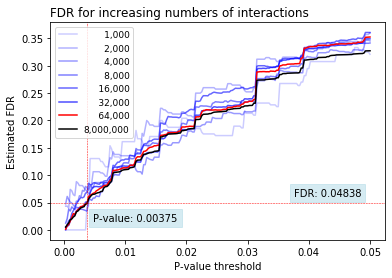

In [91]:
import matplotlib.pyplot as plt
%matplotlib inline

pval_threshs = fdr_results[1000]['RESULTS']['NOMINAL_ALPHA']

plt.plot(pval_threshs, fdr_results[1000]['RESULTS']['FDR'], color=(0,0,1,0.2), label='       ' + "{:,}".format(1000))
plt.plot(pval_threshs, fdr_results[2000]['RESULTS']['FDR'], color=(0,0,1,0.3), label='       ' + "{:,}".format(2000))
plt.plot(pval_threshs, fdr_results[4000]['RESULTS']['FDR'], color=(0,0,1,0.4), label='       ' + "{:,}".format(4000))
plt.plot(pval_threshs, fdr_results[8000]['RESULTS']['FDR'], color=(0,0,1,0.5), label='       ' + "{:,}".format(8000))
plt.plot(pval_threshs, fdr_results[16000]['RESULTS']['FDR'], color=(0,0,1,0.6), label='     ' + "{:,}".format(16000))
plt.plot(pval_threshs, fdr_results[32000]['RESULTS']['FDR'], color=(0,0,1,0.7), label='     ' + "{:,}".format(32000))
plt.plot(pval_threshs, fdr_results[64000]['RESULTS']['FDR'], color=(1,0,0,1), label='     ' + "{:,}".format(64000))
plt.plot(pval_threshs, randomize_fdr_top_8000000_fdr_list, color=(0,0,0,1), label="{:,}".format(8000000))

result_index = randomize_fdr_top_8000000.get_largest_nominal_alpha_index_at_chosen_fdr_thresh(0.05)

fdr_result = fdr_info_dict_top_8000000['RESULTS']['FDR'][result_index]
pval_thresh_result = fdr_info_dict_top_8000000['RESULTS']['NOMINAL_ALPHA'][result_index]
plt.axhline(fdr_result, linestyle='--', color='red', linewidth=0.5)
plt.axvline(pval_thresh_result, linestyle='--', color='red', linewidth=0.5)

fdr_max = max(fdr_info_dict_top_8000000['RESULTS']['FDR'])
pval_max = max(fdr_info_dict_top_8000000['RESULTS']['NOMINAL_ALPHA'])
fdr_x = pval_max - pval_max/4
fdr_y = fdr_result + fdr_max/25
pval_x = pval_thresh_result + pval_max/50
pval_y = fdr_result - fdr_max/10
plt.text(fdr_x, fdr_y,'FDR: ' + "{:.5f}".format(fdr_result), bbox={'color': 'lightblue', 'alpha': 0.5, 'pad': 4})
plt.text(pval_x, pval_y,'P-value: ' + "{:.5f}".format(pval_thresh_result), bbox={'color': 'lightblue', 'alpha': 0.5, 'pad': 4})
plt.xlabel('P-value threshold')
plt.ylabel('Estimated FDR')

plt.title('FDR for increasing numbers of interactions', loc='left')
plt.legend(loc="upper left", fontsize=9)

plt.savefig('fdr_for_increasing_numbers_of_interactions.pdf')
plt.show()

As compared to ``64,000`` input interactions, we determine the same P-value threshold of ``0.00375`` and the associated FDR (``0.04858`` vs. ``0.04838``) changes only slightly.

## Influence of different random seeds on the FDR estimation

In this section, we investigate the influence of different random seeds on the estimation of the FDR. For this purpose, we first apply our randomization procedure with ``10`` different random seeds to the same file with ``32,000`` interaction, performing only a single iteration at a time.

In [115]:
# Prepare interaction set
interaction_file_top_32000 = '../tests/data/test_03/diachromatic_interaction_file_fdr_top_32000.tsv.gz'
interaction_set_top_32000 = DiachromaticInteractionSet()
interaction_set_top_32000.parse_file(interaction_file_top_32000, verbose=False)

randomize_results = {}
i_set = interaction_set_top_32000

for random_seed in [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]:

    # Perform randomization procedure
    randomize = RandomizeInteractionSet(random_seed=random_seed)
    randomize_results[random_seed] = randomize.perform_randomization_analysis(
        interaction_set=i_set,
        nominal_alphas = nominal_alphas,
        iter_num = 1,
        thread_num = 2,
        verbose = False)
    
print("... done.")

../diachr/randomize_interaction_set.py:453: UserWarning: Failed to calculate a Z-score for at least one nominal alpha!
  warnings.warn('Failed to calculate a Z-score for at least one nominal alpha!')
../diachr/randomize_interaction_set.py:453: UserWarning: Failed to calculate a Z-score for at least one nominal alpha!
  warnings.warn('Failed to calculate a Z-score for at least one nominal alpha!')
../diachr/randomize_interaction_set.py:453: UserWarning: Failed to calculate a Z-score for at least one nominal alpha!
  warnings.warn('Failed to calculate a Z-score for at least one nominal alpha!')
../diachr/randomize_interaction_set.py:453: UserWarning: Failed to calculate a Z-score for at least one nominal alpha!
  warnings.warn('Failed to calculate a Z-score for at least one nominal alpha!')
../diachr/randomize_interaction_set.py:453: UserWarning: Failed to calculate a Z-score for at least one nominal alpha!
  warnings.warn('Failed to calculate a Z-score for at least one nominal alpha!')


... done.


../diachr/randomize_interaction_set.py:453: UserWarning: Failed to calculate a Z-score for at least one nominal alpha!
  warnings.warn('Failed to calculate a Z-score for at least one nominal alpha!')


We save the results for each random seed in a dictionary. In this way, we can afterwards compare the FDR for all random seeds in a single plot.

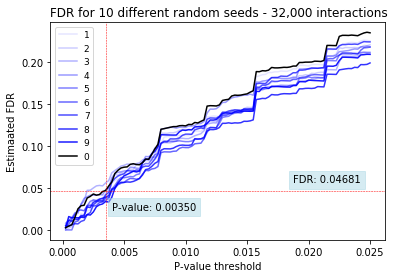

In [116]:
import matplotlib.pyplot as plt
%matplotlib inline

pval_threshs = randomize_results[0]['RESULTS']['NOMINAL_ALPHA']

plt.plot(pval_threshs, randomize_results[100]['RESULTS']['FDR'], color=(0,0,1,0.1), label="{:,}".format(1))
plt.plot(pval_threshs, randomize_results[200]['RESULTS']['FDR'], color=(0,0,1,0.2), label="{:,}".format(2))
plt.plot(pval_threshs, randomize_results[300]['RESULTS']['FDR'], color=(0,0,1,0.3), label="{:,}".format(3))
plt.plot(pval_threshs, randomize_results[400]['RESULTS']['FDR'], color=(0,0,1,0.4), label="{:,}".format(4))
plt.plot(pval_threshs, randomize_results[500]['RESULTS']['FDR'], color=(0,0,1,0.5), label="{:,}".format(5))
plt.plot(pval_threshs, randomize_results[600]['RESULTS']['FDR'], color=(0,0,1,0.6), label="{:,}".format(6))
plt.plot(pval_threshs, randomize_results[700]['RESULTS']['FDR'], color=(0,0,1,0.7), label="{:,}".format(7))
plt.plot(pval_threshs, randomize_results[800]['RESULTS']['FDR'], color=(0,0,1,0.8), label="{:,}".format(8))
plt.plot(pval_threshs, randomize_results[900]['RESULTS']['FDR'], color=(0,0,1,0.9), label="{:,}".format(9))
plt.plot(pval_threshs, randomize_results[0]['RESULTS']['FDR'], color=(0,0,0,1), label="{:,}".format(0))

result_index = 0
for fdr in randomize_results[0]['RESULTS']['FDR']:
    if fdr < 0.05:
        result_index += 1

result_index -= 1

fdr_result = randomize_results[0]['RESULTS']['FDR'][result_index]
pval_thresh_result = randomize_results[0]['RESULTS']['NOMINAL_ALPHA'][result_index]

plt.axhline(fdr_result, linestyle='--', color='red', linewidth=0.5)
plt.axvline(pval_thresh_result, linestyle='--', color='red', linewidth=0.5)

fdr_max = max(randomize_results[0]['RESULTS']['FDR'])
pval_max = max(randomize_results[0]['RESULTS']['NOMINAL_ALPHA'])

fdr_x = pval_max - pval_max/4
fdr_y = fdr_result + fdr_max/25
pval_x = pval_thresh_result + pval_max/50
pval_y = fdr_result - fdr_max/10
plt.text(fdr_x, fdr_y,'FDR: ' + "{:.5f}".format(fdr_result), bbox={'color': 'lightblue', 'alpha': 0.5, 'pad': 4})
plt.text(pval_x, pval_y,'P-value: ' + "{:.5f}".format(pval_thresh_result), bbox={'color': 'lightblue', 'alpha': 0.5, 'pad': 4})
plt.xlabel('P-value threshold')
plt.ylabel('Estimaated FDR')

plt.title('FDR for 10 different random seeds - 32,000 interactions', loc='left')
plt.legend(fontsize=9)

plt.savefig('fdr_for_10_different_random_seeds_32000.pdf')
plt.show()

It can be seen that the results vary depending on the random seeds.

Next, we perform the same analysis with ``10`` iterations each.

In [111]:
randomize_results = {}
i_set = interaction_set_top_32000

for random_seed in [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]:

    # Perform randomization procedure
    randomize = RandomizeInteractionSet(random_seed=random_seed)
    randomize_results[random_seed] = randomize.perform_randomization_analysis(
        interaction_set=i_set,
        nominal_alphas = nominal_alphas,
        iter_num = 10,
        thread_num = 2,
        verbose = False)
    
print("... done.")

... done.


We compare the FDR again in a single plot.

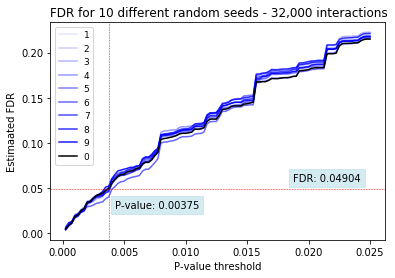

In [114]:
import matplotlib.pyplot as plt
%matplotlib inline

pval_threshs = randomize_results[0]['RESULTS']['NOMINAL_ALPHA']

plt.plot(pval_threshs, randomize_results[100]['RESULTS']['FDR'], color=(0,0,1,0.1), label="{:,}".format(1))
plt.plot(pval_threshs, randomize_results[200]['RESULTS']['FDR'], color=(0,0,1,0.2), label="{:,}".format(2))
plt.plot(pval_threshs, randomize_results[300]['RESULTS']['FDR'], color=(0,0,1,0.3), label="{:,}".format(3))
plt.plot(pval_threshs, randomize_results[400]['RESULTS']['FDR'], color=(0,0,1,0.4), label="{:,}".format(4))
plt.plot(pval_threshs, randomize_results[500]['RESULTS']['FDR'], color=(0,0,1,0.5), label="{:,}".format(5))
plt.plot(pval_threshs, randomize_results[600]['RESULTS']['FDR'], color=(0,0,1,0.6), label="{:,}".format(6))
plt.plot(pval_threshs, randomize_results[700]['RESULTS']['FDR'], color=(0,0,1,0.7), label="{:,}".format(7))
plt.plot(pval_threshs, randomize_results[800]['RESULTS']['FDR'], color=(0,0,1,0.8), label="{:,}".format(8))
plt.plot(pval_threshs, randomize_results[900]['RESULTS']['FDR'], color=(0,0,1,0.9), label="{:,}".format(9))
plt.plot(pval_threshs, randomize_results[0]['RESULTS']['FDR'], color=(0,0,0,1), label="{:,}".format(0))

result_index = 0
for fdr in randomize_results[0]['RESULTS']['FDR']:
    if fdr < 0.05:
        result_index += 1

result_index -= 1

fdr_result = randomize_results[0]['RESULTS']['FDR'][result_index]
pval_thresh_result = randomize_results[0]['RESULTS']['NOMINAL_ALPHA'][result_index]

plt.axhline(fdr_result, linestyle='--', color='red', linewidth=0.5)
plt.axvline(pval_thresh_result, linestyle='--', color='red', linewidth=0.5)

fdr_max = max(randomize_results[0]['RESULTS']['FDR'])
pval_max = max(randomize_results[0]['RESULTS']['NOMINAL_ALPHA'])

fdr_x = pval_max - pval_max/4
fdr_y = fdr_result + fdr_max/25
pval_x = pval_thresh_result + pval_max/50
pval_y = fdr_result - fdr_max/10
plt.text(fdr_x, fdr_y,'FDR: ' + "{:.5f}".format(fdr_result), bbox={'color': 'lightblue', 'alpha': 0.5, 'pad': 4})
plt.text(pval_x, pval_y,'P-value: ' + "{:.5f}".format(pval_thresh_result), bbox={'color': 'lightblue', 'alpha': 0.5, 'pad': 4})
plt.xlabel('P-value threshold')
plt.ylabel('Estimaated FDR')

plt.title('FDR for 10 different random seeds - 32,000 interactions', loc='left')
plt.legend(fontsize=9)

plt.savefig('fdr_for_10_different_random_seeds_32000.pdf')
plt.show()

It can be seen that the FDR fluctuates much less when ``10`` instead of only one random seeds are used. With ``50`` iterations there are alomost no more fluctuations (run the penultimate cell with ``iter_num=50``). Note that each iteration has its own random seed, i.e. each line in the plot is based on ``10`` random seeds.

## Integration of the FDR module in the script for evaluation and categorization of interactions

We have integrated the FDR module into the script for evaluating and categorizing interactions. If this script is called without a P-value threshold being passed, a P-value threshold is determined using the FDR procedure.

In [1]:
%run ../03_evaluate_and_categorize_interactions.py \
--out-prefix DEMO \
--diachromatic-interaction-file ../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz \
--fdr-random-seed 0

[INFO] Input parameters
	[INFO] --out-prefix: DEMO
	[INFO] --diachromatic-interaction-file: ../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz
	[INFO] --p-value-threshold: None
		[INFO] Will determine a P-value threshold so that the FDR is kept below: 0.05
		[INFO] Will use a P-value threshold step size of: 1e-05
		[INFO] Random seed: 0
		[INFO] Use '--fdr-threshold' to set your own FDR threshold.
		[INFO] Or use '--p-value-threshold' to skip the FDR procedure.

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz
	[INFO] Set size: 64,000
[INFO] ... done.

[INFO] Performing randomization analysis with 100 iterations ...
	[INFO] Determining number of significant interactions at each nominal alpha ...
	[INFO] Randomizing interactions ...
		[INFO] Created RP_INTER_DICT for 54,742 interactions ...
		[INFO] Performing 50 iterations ...
			[INFO] First iteration indices: 0, 1, 2, 3, 4, 5, 6, 7,

In this case, the file with the summary statistics is extended to include the corresponding report (``[INFO] Report on FDR procedure``) and table rows (``:TR_FDR:``).

In [34]:
cat DEMO_evaluated_and_categorized_summary.txt

[INFO] Input parameters
	[INFO] --out-prefix: DEMO
	[INFO] --diachromatic-interaction-file: ../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz
	[INFO] --p-value-threshold: None
		[INFO] Will determine a P-value threshold so that the FDR is kept below: 0.05
		[INFO] Will use a P-value threshold step size of: 0.00025
		[INFO] Random seed: 0
		[INFO] Use '--fdr-threshold' to set your own FDR threshold.
		[INFO] Or use '--p-value-threshold' to skip the FDR procedure.

[INFO] Report on reading files:
	[INFO] Read interaction data from 1 files:
		[INFO] 64,000 interactions from: 
			[INFO] ../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz
			[INFO] Set size: 64,000
	[INFO] The interaction set has 64,000 interactions.
[INFO] End of report.

[INFO] Report on FDR procedure:
	[INFO] Input parameters:
		[INFO] Chosen FDR threshold: 0.05000
		[INFO] Maximum P-value threshold: 0.05000
		[INFO] P-value threshold step size: 0.00025
		[INFO] Total number of